In [1]:
import psycopg2
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from numpy import random

from sklearn.preprocessing import StandardScaler

import os
os.chdir('/home/rafalb/work/molecules/chemicalSmilesSpace/src')

from keras.layers import LSTM, TimeDistributed, concatenate, Input, Dense, RepeatVector, Lambda,  Convolution1D, Flatten, GRU, BatchNormalization, Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, tanh
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
import keras.backend as K
from keras.utils import plot_model
from keras import losses
from keras import objectives
import numpy.random as rnd

from trainHistory import trainHistory
import datetime


Using TensorFlow backend.


In [2]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
def prepare_model(static, dynamic, k, window, charsetLen, lr, lossFunction, showArch):
    input_dynamic = Input(shape=(window, charsetLen), name="input_dynamic")
    input_static = Input(shape=(static,), name="input_static")
    latent = Dense(k[0], activation=relu)(input_static)
    dense_h = Dense(k[0])(latent)
    dense_c = Dense(k[0])(latent)
    lstm_layer, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic,
                                                                                        initial_state=[dense_h,
                                                                                                       dense_c])

    for x in k[1:-1]:
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer,
                                                                                         initial_state=[dense_h,
                                                                                                        dense_c])
    x = k[-1]
    concat_h = concatenate([dense_h, state_h])
    dense_h = Dense(x)(concat_h)
    concat_c = concatenate([dense_c, state_c])
    dense_c = Dense(x)(concat_c)
    lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer, initial_state=[dense_h, dense_c])
    concat = concatenate([lstm_layer, latent])

    # autoencoder
    z_mean = Dense(x, name='z_mean')(concat)
    z_log_var = Dense(x, name='z_log_var')(concat)


    z = Lambda(sampling, output_shape=(x,), name='z')([z_mean, z_log_var])



    state_h = Dense(k[-2], activation=relu)(z)
    dense_h = Dense(k[-2], activation=relu)(z)
    state_c = Dense(k[-2], activation=relu)(z)
    dense_c = Dense(k[-2], activation=relu)(z)
    lstm_layer = RepeatVector(window)(z)

    for x in np.flip(k[:-1]):
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer,
                                                                                         initial_state=[dense_h,
                                                                                                        dense_c])

    #result_series = TimeDistributed(Dense(charsetLen))(lstm_layer)
    result_series = LSTM(charsetLen, return_sequences=True, activation='softmax')(lstm_layer)
    concat = concatenate([state_h, state_c])
    #result_sigmoid = Dense(static-3, activation=sigmoid)(concat)
    result_relu = Dense(static, activation=sigmoid)(concat)
    
    #model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_sigmoid, result_relu])
    model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_relu])
    optimizer = RMSprop(lr=lr)
    model.compile(optimizer=optimizer, loss=lossFunction, metrics=['binary_crossentropy', 'mean_absolute_error'])
    if (showArch):
        print(model.summary())
    return model


In [5]:
def prepareModelOnlyDynamic(dynamicDim, k, lr, lossFunction, showArch):
    input_dynamic = Input(shape=(dynamicDim[1], dynamicDim[2]), name="inputDynamic")
    lstm_layer, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic)

    for x in k[1:-1]:
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer)

    x = k[-1]

    lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer)

    # autoencoder
    z_mean = Dense(x, name='z_mean')(lstm_layer)
    z_log_var = Dense(x, name='z_log_var')(lstm_layer)

    z = Lambda(sampling, output_shape=(x,), name='z')([z_mean, z_log_var])

    lstm_layer = RepeatVector(dynamicDim[1])(z)

    for x in np.flip(k[:-1]):
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer)

    #result_series = TimeDistributed(Dense(charsetLen))(lstm_layer)
    result_series = LSTM(dynamicDim[2], return_sequences=True, activation='softmax')(lstm_layer)

    #model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_sigmoid, result_relu])
    model = Model(inputs=[input_dynamic], outputs=[result_series])
    optimizer = RMSprop(lr=lr)
    model.compile(optimizer=optimizer, loss=lossFunction, metrics=['binary_crossentropy', 'mean_absolute_error'])
    if (showArch):
        print(model.summary())
    return model

In [6]:
def prepareEncoderDynamic(nCharInSmiles, nCharSet, k, lr, variational, showArch):

    input_dynamic = Input(shape=(nCharInSmiles, nCharSet), name="inputDynamic")
    encoder, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic)

    for x in k[1:-1]:
        encoder, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(encoder)


    #states = concatenate([state_h, state_c])
    #encoder, state_h, state_c = LSTM(k[-2], return_sequences=False, return_state=True)(encoder)

    x = k[-1]
    encoder, state_h, state_c = LSTM(x, return_state=True, return_sequences=False)(encoder)
    concat = concatenate([encoder, state_h])
    output = Dense(x, activation='relu')(concat)
    #concat = concatenate([concat, encoder])

    # autoencoder
    if (variational):
        #z_mean = Dense(x, name='z_mean')(encoder)
        #z_log_var = Dense(x, name='z_log_var')(encoder)
        z_mean = Dense(x, name='z_mean')(output)
        z_log_var = Dense(x, name='z_log_var')(output)
        z = Lambda(sampling, output_shape=(x,), name='encoderOutput')([z_mean, z_log_var])
        z = Dense(x, activation='relu')(z)
        def vae_loss(x, x_decoded_mean):
            x = K.flatten(x)
            x_decoded_mean = K.flatten(x_decoded_mean)
            xent_loss = nCharInSmiles * objectives.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
            return xent_loss + kl_loss
    else:
        z = Dense(x, activation="relu", name='encoderOutput')(encoder)
        vae_loss = None



    model = Model(inputs=[input_dynamic], outputs=[z])
    if (showArch):
        print(model.summary())

    return model, vae_loss

In [7]:
def prepareEncoderCNNDynamic(nCharInSmiles, nCharSet, k, lr, variational, showArch):

    convDefinition = k[0]
    input_dynamic = Input(shape=(nCharInSmiles, nCharSet), name="inputDynamic")
    h = Convolution1D(convDefinition['initialDimWidth'], convDefinition['initialDimDepth'], activation = 'relu', name='conv_0')(input_dynamic)

    for iLayer in range(convDefinition['nCNNlayers'] - 1):
        iWidth = int(convDefinition['initialDimDepth'] * convDefinition['expansionCoeff'] ** iLayer)
        iDepth = int(convDefinition['initialDimDepth'] * convDefinition['expansionCoeff'] ** iLayer)
        h = Convolution1D(iWidth, iDepth, activation = 'relu', name='conv_'+str(iLayer+1))(h)
        #h = Dropout(0.1)(h)
        h = BatchNormalization()(h)

    h = Flatten(name='flatten_1')(h)
    output = Dense(k[1], activation = 'relu', name='dense_1')(h)

    # autoencoder
    if (variational):
        #z_mean = Dense(x, name='z_mean')(encoder)
        #z_log_var = Dense(x, name='z_log_var')(encoder)
        z_mean = Dense(k[1], name='z_mean')(output)
        z_log_var = Dense(k[1], name='z_log_var')(output)
        z = Lambda(sampling, output_shape=(k[1],), name='encoderOutput')([z_mean, z_log_var])
        def vae_loss(x, x_decoded_mean):
            x = K.flatten(x)
            x_decoded_mean = K.flatten(x_decoded_mean)
            xent_loss = nCharInSmiles * objectives.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
            return xent_loss + kl_loss
    else:
        z = Dense(k[1], activation="relu", name='encoderOutput')(output)
        vae_loss = None


    model = Model(inputs=[input_dynamic], outputs=[z])
    if (showArch):
        print(model.summary())

    return model, vae_loss

In [8]:
def prepareDecoderDynamic(nCharInSmiles, nCharSet, k, lr, showArch):
    decoderInput = Input(shape=(k[-1],), name="decoderInput")

    state_h_decoded  = Dense(k[-2], activation="relu")(decoderInput)
    state_c_decoded  = Dense(k[-2], activation="relu")(decoderInput)
    encoder_states = [state_h_decoded, state_c_decoded]

    decoder = RepeatVector(nCharInSmiles, name='repeat')(decoderInput)
    decoder, state_h, state_c = LSTM(k[-2], return_sequences=True, return_state=True)(decoder, initial_state=encoder_states)
    for x in np.flip(k[:-1]):
        decoder, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(decoder)

    #result_series = TimeDistributed(Dense(charsetLen))(lstm_layer)
    resultDynamic = TimeDistributed(Dense(nCharSet, activation='softmax'))(decoder)
    #resultDynamic = LSTM(nCharSet, activation='softmax', name = 'outputDynamic')(decoder)

    model = Model(inputs=[decoderInput], outputs=[resultDynamic])
    if (showArch):
        print(model.summary())

    return model

In [9]:
def prepareDecoderCNNDynamic(nCharInSmiles, nCharSet, k, lr, showArch):
    decoderInput = Input(shape=(k[0],), name="decoderInput")

    h = Dense(k[0], name='latent_input', activation = 'relu')(decoderInput)
    h = RepeatVector(nCharInSmiles, name='repeat_vector')(h)
    for idx, iLayer in enumerate(k[1:]):
        h = GRU(iLayer, return_sequences = True, name='gru_'+str(idx))(h)
        #h = Dropout(0.1)(h)

    resultDynamic = TimeDistributed(Dense(nCharSet, activation='softmax'), name='decoded_mean')(h)

    model = Model(inputs=[decoderInput], outputs=[resultDynamic])
    if (showArch):
        print(model.summary())

    return model

In [10]:
def prepareDecoderCNN_LSTMDynamic(nCharInSmiles, nCharSet, k, lr, showArch):
    decoderInput = Input(shape=(k[0],), name="decoderInput")

    h = Dense(k[0], name='latent_input', activation = 'relu')(decoderInput)
    h = RepeatVector(nCharInSmiles, name='repeat_vector')(h)
    for idx, iLayer in enumerate(k[1:]):
        h = LSTM(iLayer, return_sequences = True, name='lstm_'+str(idx))(h)

    resultDynamic = TimeDistributed(Dense(nCharSet, activation='softmax'), name='decoded_mean')(h)

    model = Model(inputs=[decoderInput], outputs=[resultDynamic])
    if (showArch):
        print(model.summary())

In [12]:
def prepareEncoder(nCharInSmiles, nCharSet, nStatic, k, lr, lossFunction, showArch):

    input_dynamic = Input(shape=(nCharInSmiles, nCharSet), name="inputDynamic")
    input_static = Input(shape=(nStatic,), name="inputStatic")

    latent = Dense(k[0], activation=relu)(input_static)
    dense_h = Dense(k[0])(latent)
    dense_c = Dense(k[0])(latent)

    encoder, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic, initial_state=[dense_h, dense_c])

    for x in k[1:-1]:
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        encoder, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(encoder, initial_state = [dense_h, dense_c])

    x = k[-1]
    concat_h = concatenate([dense_h, state_h])
    dense_h = Dense(x)(concat_h)
    concat_c = concatenate([dense_c, state_c])
    dense_c = Dense(x)(concat_c)
    encoder, state_h, state_c = LSTM(x, return_state=True)(encoder, initial_state=[dense_h, dense_c])
    concat = concatenate([encoder, latent])

    # autoencoder
    z_mean = Dense(x, name='z_mean')(concat)
    z_log_var = Dense(x, name='z_log_var')(concat)

    z = Lambda(sampling, output_shape=(x,), name='encoderOutput')([z_mean, z_log_var])

    #state_h = Dense(k[-2], activation=relu)(z)
    #dense_h = Dense(k[-2], activation=relu)(z)
    #state_c = Dense(k[-2], activation=relu)(z)
    #dense_c = Dense(k[-2], activation=relu)(z)
    #encoder = RepeatVector(dynamicDim[1])(z)

    model = Model(inputs=[input_dynamic, input_static], outputs=[z])
    if (showArch):
        print(model.summary())

    return model

In [13]:
def prepareDecoder(nCharInSmiles, nCharSet, nStatic, k, lr, lossFunction, showArch):
    decoderInput = Input(shape=(k[-1],), name="decoderInput")
    state_h = Dense(k[-2], activation=relu, name='ini_state_h')(decoderInput)
    dense_h = Dense(k[-2], activation=relu, name='ini_dense_h')(decoderInput)
    state_c = Dense(k[-2], activation=relu, name='ini_state_c')(decoderInput)
    dense_c = Dense(k[-2], activation=relu, name='ini_dense_c')(decoderInput)
    decoder = RepeatVector(nCharInSmiles, name='repeat')(decoderInput)

    for x in np.flip(k[:-1]):
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        decoder, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(decoder)

    #result_series = TimeDistributed(Dense(charsetLen))(lstm_layer)
    resultDynamic = LSTM(nCharSet, return_sequences=True, activation='softmax', name = 'outputDynamic')(decoder)

    concat = concatenate([state_h, state_c])
    resultStatic = Dense(nStatic, activation=sigmoid, name = 'outputStatic')(concat)

    model = Model(inputs=[decoderInput], outputs=[resultDynamic, resultStatic])
    if (showArch):
        print(model.summary())

    return model

In [14]:
def prepareModelDynamicStatic(dynamicDim, staticDim, k, lr, lossFunction, showArch):

    input_dynamic = Input(shape=(dynamicDim[1], dynamicDim[2]), name="inputDynamic")
    input_static = Input(shape=(staticDim[1],), name="inputStatic")

    latent = Dense(k[0], activation=relu)(input_static)
    dense_h = Dense(k[0])(latent)
    dense_c = Dense(k[0])(latent)

    lstm_layer, state_h, state_c = LSTM(k[0], return_sequences=True, return_state=True)(input_dynamic, initial_state=[dense_h, dense_c])

    for x in k[1:-1]:
        concat_h = concatenate([dense_h, state_h])
        dense_h = Dense(x)(concat_h)
        concat_c = concatenate([dense_c, state_c])
        dense_c = Dense(x)(concat_c)
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer, initial_state = [dense_h, dense_c])

    x = k[-1]
    concat_h = concatenate([dense_h, state_h])
    dense_h = Dense(x)(concat_h)
    concat_c = concatenate([dense_c, state_c])
    dense_c = Dense(x)(concat_c)
    lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer, initial_state=[dense_h, dense_c])
    concat = concatenate([lstm_layer, latent])


    #lstm_layer, state_h, state_c = LSTM(x, return_state=True)(lstm_layer)

    # autoencoder
    z_mean = Dense(x, name='z_mean')(concat)
    z_log_var = Dense(x, name='z_log_var')(concat)

    z = Lambda(sampling, output_shape=(x,), name='z')([z_mean, z_log_var])

    state_h = Dense(k[-2], activation=relu)(z)
    dense_h = Dense(k[-2], activation=relu)(z)
    state_c = Dense(k[-2], activation=relu)(z)
    dense_c = Dense(k[-2], activation=relu)(z)
    lstm_layer = RepeatVector(dynamicDim[1])(z)

    for x in np.flip(k[:-1]):
        lstm_layer, state_h, state_c = LSTM(x, return_sequences=True, return_state=True)(lstm_layer)

    #result_series = TimeDistributed(Dense(charsetLen))(lstm_layer)
    result_series = LSTM(dynamicDim[2], return_sequences=True, activation='softmax', name = 'outputDynamic')(lstm_layer)

    concat = concatenate([state_h, state_c])
    result_static = Dense(staticDim[1], activation=sigmoid, name = 'outputStatic')(concat)

    #model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_sigmoid, result_relu])
    model = Model(inputs=[input_dynamic, input_static], outputs=[result_series, result_static])
    optimizer = RMSprop(lr=lr)
    model.compile(optimizer=optimizer, loss=lossFunction, metrics=['binary_crossentropy', 'mean_absolute_error'])
    if (showArch):
        print(model.summary())
    return model


In [15]:
def fit(staticFeatures, dynamicFeatures, model, step=1):
    #dynamic_data = np.empty((0, window, 1), np.float)
    #helper = []
    #for d in dynamic:
    #    new_data = rolling_window(d, window, step)
    #    helper.append(len(new_data))
    #    dynamic_data = np.append(dynamic_data, new_data, axis=0)
    #print(len(helper))
    #static_data = np.repeat(static, helper, axis=0)
    order = rnd.permutation(len(staticFeatures))

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = 'autoencoder.h5'
    checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, monitor='val_loss')

    size = int(staticFeaturesSta.shape[0] * 0.9)
    training_dynamic, training_static = dynamicFeatures[order[:size]], staticFeatures[order[:size]]
    testing_dynamic, testing_static = dynamicFeatures[order[size:]], staticFeatures[order[size:]]
    print(training_dynamic.shape, training_static.shape)
    print(testing_dynamic.shape, testing_static.shape)
    model.fit([training_dynamic, training_static],
              [training_dynamic, training_static],
                   epochs=10,
                   batch_size=64,
                   callbacks=[early_stopping, checkpoint],
                   validation_data=([testing_dynamic, testing_static],
                                    [testing_dynamic, testing_static]))


In [16]:
def fitOnlyDynamic(dynamicFeatures, model, modelFilePath, nEpoch, nBatch, iniLR):
    dtime = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    order = rnd.permutation(len(staticFeatures))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    checkpoint = ModelCheckpoint(modelFilePath, save_best_only=True, save_weights_only=False, monitor='val_loss')

    size = int(dynamicFeatures.shape[0] * 0.9)
    training_dynamic = dynamicFeatures[order[:size]]
    testing_dynamic = dynamicFeatures[order[size:]]
    print(training_dynamic.shape)
    print(testing_dynamic.shape)

    optimizationEvolution = trainHistory(iniLR, 0.5, 20, dtime)

    history = model.fit(training_dynamic,
              training_dynamic,
                   epochs=nEpoch,
                   batch_size=nBatch,
                   #callbacks=[early_stopping, checkpoint, optimizationEvolution],
                   callbacks=[early_stopping, checkpoint],
                   validation_data=(testing_dynamic,
                                    testing_dynamic))
    return model, history

In [17]:
def fitDynamicStatic(dynamicFeatures, staticFeatures, model, modelFilePath, nEpoch, nBatch):
    order = rnd.permutation(len(staticFeatures))

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    checkpoint = ModelCheckpoint(modelFilePath, save_best_only=True, save_weights_only=True, monitor='val_loss')

    size = int(staticFeatures.shape[0] * 0.9)
    training_dynamic, training_static = dynamicFeatures[order[:size]], staticFeatures[order[:size]]
    testing_dynamic, testing_static = dynamicFeatures[order[size:]], staticFeatures[order[size:]]
    print(training_dynamic.shape, training_static.shape)
    print(testing_dynamic.shape, testing_static.shape)
    history = model.fit([training_dynamic, training_static],
              [training_dynamic, training_static],
              epochs=nEpoch,
              batch_size=nBatch,
              callbacks=[early_stopping, checkpoint],
              validation_data=([testing_dynamic, testing_static],
                                    [testing_dynamic, testing_static]))
    return model, history

In [18]:
def pad_smile(string, max_len, padding='right'):
    if len(string) <= max_len:
        if padding == 'right':
            return string + " " * (max_len - len(string))
        elif padding == 'left':
            return " " * (max_len - len(string)) + string
        elif padding == 'none':
            return string

In [19]:
def prepareData(dataFile, nSample, minNsmiles, maxMsmiles, doPlot = False):

    with open(dataFile, 'rb') as file:
        molDataGroupedChosen = pickle.load(file)

    #nSmilesCodes = 200000
    nSmilesMore = np.min([molDataGroupedChosen.shape[0], int(1.2*nSample)])
    mask = random.randint(0, molDataGroupedChosen.shape[0], size = nSmilesMore)
    #mask = random.randint(0, molDataGroupedChosen.shape[0], size=nSmilesCodes)
    mask = molDataGroupedChosen.index
    staticFeatures = pd.DataFrame()
    toBeAveraged = ['standard_value', 'alogp', 'hba', 'hbd', 'psa', 'rtb', 'full_mwt', 'qed_weighted']
    for quantity in toBeAveraged:
        staticFeatures.loc[:, quantity] = (molDataGroupedChosen.loc[mask, (quantity, 'min')] + molDataGroupedChosen.loc[mask, (quantity, 'max')])/2
        staticFeatures.loc[:, quantity].astype(float)
    toBeTaken = ['aromatic_rings', 'heavy_atoms']
    for quantity in toBeTaken:
        staticFeatures.loc[:, quantity] = molDataGroupedChosen.loc[mask, (quantity, 'min')]
        staticFeatures.loc[:, quantity].astype(float)
    staticFeatures.loc[:, 'number_of_rings'] = molDataGroupedChosen.loc[mask, 'numberOfRings'].astype(float)

    staticFeatures['full_mwt'] = staticFeatures.full_mwt.astype(float)
    staticFeatures['qed_weighted'] = staticFeatures.qed_weighted.astype(float)
    staticFeatures['aromatic_rings'] = staticFeatures.aromatic_rings.astype(float)
    staticFeatures['smiles_length'] = molDataGroupedChosen.loc[staticFeatures.index, 'canonicalSmiles'].apply(lambda x: len(x))


    # Remove rows with nans
    staticFeatures = staticFeatures.dropna()

    # Filter the smiles from given length range
    staticFeatures = staticFeatures[(staticFeatures['smiles_length'] >= minNsmiles) & (staticFeatures['smiles_length'] <= maxMsmiles)]

    thres = 100000
    print(staticFeatures[staticFeatures['standard_value'] < thres].shape[0] / staticFeatures['standard_value'].shape[0])

    staticFeatures = staticFeatures[staticFeatures['standard_value'] < thres]

    staticFeatures = staticFeatures.sample(nSample)

    allDescriptors = ['standard_value', 'alogp', 'hba', 'hbd', 'psa', 'rtb', 'full_mwt', 'qed_weighted', 'aromatic_rings', 'heavy_atoms', 'number_of_rings', 'smiles_length']

    if (doPlot):
        plotIdx = 1
        nRows = np.ceil(len(allDescriptors) / 2)
        fig = plt.figure(figsize=(16, 16))
        for quantity in allDescriptors:
            print(quantity)
            plt.subplot(nRows, 2, plotIdx)
            plt.hist(staticFeatures[~staticFeatures[quantity].isnull()][quantity], bins = 10)
            plt.title(quantity)
            plotIdx += 1

    smilesCodes = molDataGroupedChosen.loc[staticFeatures.index, 'encodedSmiles']
    
    maxlen = -1
    for code in smilesCodes:
        if len(code) > maxlen:
            maxlen = len(code)
    maxlen

    minlen = 1e6
    for code in smilesCodes:
        if len(code) < minlen:
            minlen = len(code)
    minlen

    # pad the codes to the longest code
    smilesCodes = smilesCodes.apply(lambda x: pad_smile(x, max_len=maxlen, padding='right'))

    chars = sorted(list(set(smilesCodes.str.cat(sep=''))))
    print('total chars:', len(chars))
    print(chars)
    char2indices = dict((c, i) for i, c in enumerate(chars))
    indices2char = dict((i, c) for i, c in enumerate(chars))

    dynamicFeatures = np.zeros((len(smilesCodes), maxlen, len(chars)), dtype=np.float)
    print(dynamicFeatures.shape)

    for codeidx, code in enumerate(smilesCodes):
        for charidx, char in enumerate(code):
            dynamicFeatures[codeidx, charidx, char2indices[char]] = 1

    if (doPlot):
        sums = []
        for idx in range(dynamicFeatures.shape[0]):
            sums.append(np.sum(dynamicFeatures[idx, :, :]))
        plt.hist(sums)

    return staticFeatures, dynamicFeatures, smilesCodes, char2indices, indices2char

In [20]:
def scaleFeatures(staticFeatures):
# Choose some subset of dynamicFeatures

    scaler = StandardScaler()
    scaler.fit(staticFeatures)

    return scaler.transform(staticFeatures, ), scaler

In [21]:
def trainModel(dynamicFeatures, staticFeatures, aeDimensions, modelFile, nEpoch, nBatch):
    lr = 0.01
    nCharInSmiles = dynamicFeatures.shape[1]
    nCharSet = dynamicFeatures.shape[2]
    nStatic = staticFeatures.shape[1]

    encoder = prepareEncoder(nCharInSmiles, nCharSet, nStatic, aeDimensions, lr, ['binary_crossentropy', 'mean_absolute_error'], True)
    decoder = prepareDecoder(nCharInSmiles, nCharSet, nStatic, aeDimensions, lr, ['binary_crossentropy', 'mean_absolute_error'], True)
    encoderOutput = encoder.get_layer('encoderOutput').output
    decoderOutput = decoder(encoderOutput)
    autoencoder = Model(inputs=encoder.input, outputs=decoderOutput)

    optimizer = RMSprop(lr=lr)
    autoencoder.compile(optimizer=optimizer, loss=['categorical_crossentropy', 'mean_absolute_error'], metrics=['binary_crossentropy', 'mean_absolute_error', 'accuracy'])

    print(autoencoder.summary())
    #model = prepareModelDynamicStatic(dynamicFeatures.shape, staticFeatures.shape, [64,64,64,32], lr, ['binary_crossentropy', 'mean_absolute_error'], True)
    model, history = fitDynamicStatic(dynamicFeatures, staticFeatures, autoencoder, modelFile, nEpoch, nBatch)
    return model, history

In [22]:
def trainModelDynamic(dynamicFeatures, encoderDimensions, decoderDimensions, modelFile, nEpoch, nBatch, lr):
    nCharInSmiles = dynamicFeatures.shape[1]
    nCharSet = dynamicFeatures.shape[2]
    decoderChoice = 0
    variational = True
    encoder, vae_loss = prepareEncoderCNNDynamic(nCharInSmiles, nCharSet, encoderDimensions, lr, True, True)
    if decoderChoice == 0:
        decoder = prepareDecoderCNNDynamic(nCharInSmiles, nCharSet, decoderDimensions, lr, True)
    elif decoderChoice == 1:
        decoder = prepareDecoderCNN_LSTMDynamic(nCharInSmiles, nCharSet, decoderDimensions, lr, True)
    encoderOutput = encoder.get_layer('encoderOutput').output
    decoderOutput = decoder(encoderOutput)
    autoencoder = Model(inputs=encoder.input, outputs=decoderOutput)

    #optimizer = RMSprop(lr=lr)
    optimizer = Adam(lr)
    if variational:
        lossF = vae_loss
    else:
        loddF = 'categorical_crossentropy'

    autoencoder.compile(optimizer=optimizer, loss=lossF, metrics=['categorical_crossentropy', 'mean_absolute_error', 'accuracy'])

    print(autoencoder.summary())
    #model = prepareModelDynamicStatic(dynamicFeatures.shape, staticFeatures.shape, [64,64,64,32], lr, ['binary_crossentropy', 'mean_absolute_error'], True)
    model, history = fitOnlyDynamic(dynamicFeatures, autoencoder, modelFile, nEpoch, nBatch, lr)
    return model, history

In [ ]:
#!/bin/bash
python trainSmiles.py -dataFile ../data/processed/molDataGroupedFinal.pckl 
-modelWeightsFile model_20191126.h5 -completeModel predictiveModel_20191126.pckl 
-nSample 300000 -nBatch 196 -nEpoch 256

0.959869358164849
standard_value
alogp
hba
hbd
psa
rtb
full_mwt
qed_weighted
aromatic_rings
heavy_atoms
number_of_rings
smiles_length
total chars: 27
[' ', '#', '(', ')', '-', '.', '1', '2', '3', '4', '5', '=', 'C', 'F', 'G', 'I', 'N', 'O', 'P', 'S', 'U', 'W', '[', ']', 'c', 'o', 's']
(100000, 100, 27)


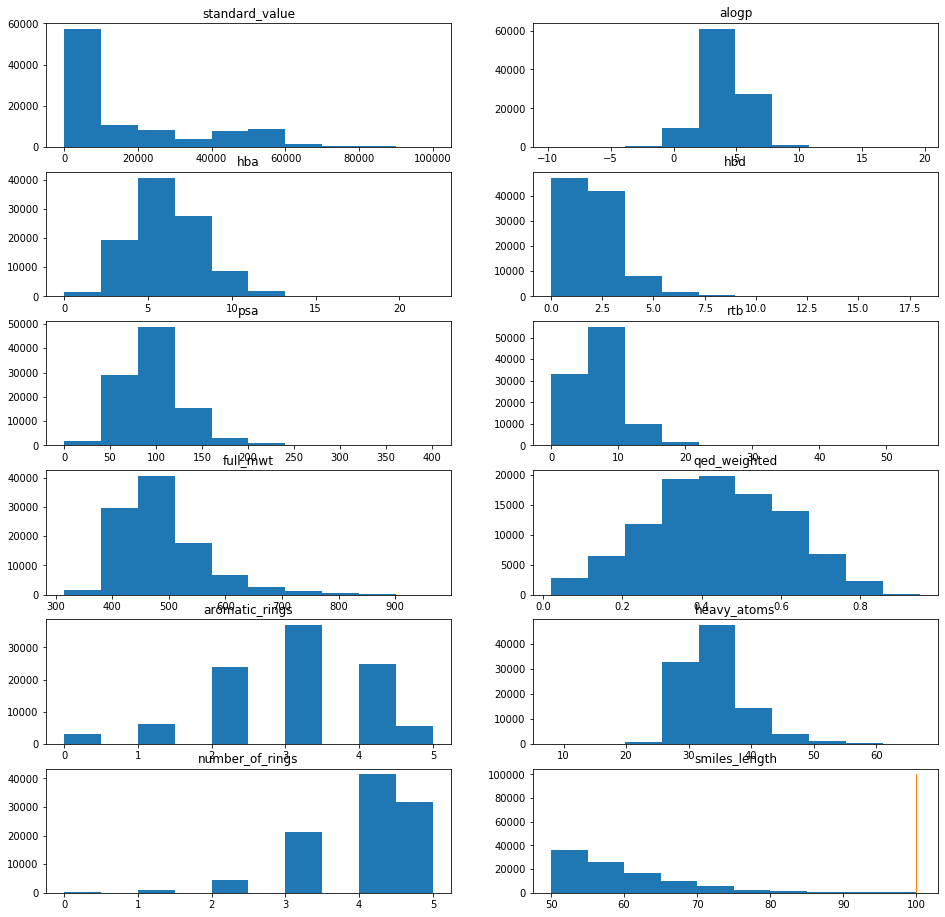

In [53]:
dataFile = '../data/processed/molDataGroupedFinal.pckl'
nSample = 100000
staticFeatures, dynamicFeatures, smilesCodes, char2indices, indices2char = \
prepareData(dataFile, nSample, 50, 100, doPlot = True)

In [64]:
char2indices

{' ': 0,
 '#': 1,
 '(': 2,
 ')': 3,
 '-': 4,
 '.': 5,
 '1': 6,
 '2': 7,
 '3': 8,
 '4': 9,
 '5': 10,
 '=': 11,
 'C': 12,
 'F': 13,
 'G': 14,
 'I': 15,
 'N': 16,
 'O': 17,
 'P': 18,
 'S': 19,
 'U': 20,
 'W': 21,
 '[': 22,
 ']': 23,
 'c': 24,
 'o': 25,
 's': 26}

In [25]:
staticFeatures.shape

(100000, 12)

In [79]:
staticFeatures.head()

,standard_value,alogp,hba,hbd,psa,rtb,full_mwt,qed_weighted,aromatic_rings,heavy_atoms,number_of_rings,smiles_length
109688,2090.00,6.19,6.0,1.0,76.07,10.0,573.61,0.23,3.0,39.0,4.0,67
480655,44662.80,3.81,5.0,3.0,121.80,6.0,418.41,0.41,3.0,31.0,3.0,53
204616,6650.00,4.66,6.0,1.0,62.30,8.0,502.90,0.42,3.0,29.0,4.0,50
779174,50290.25,2.07,8.0,2.0,94.22,9.0,475.63,0.41,1.0,34.0,4.0,55
81903,1305.00,3.67,5.0,2.0,92.26,5.0,444.49,0.63,3.0,33.0,4.0,54


In [55]:
dynamicFeatures.shape[2]

27

In [56]:
dynamicFeatures[0, :, :]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [57]:
def createSmiles(prediction, nCharInSmiles, inidices2char):
    smiles = []
    for iii in range(nCharInSmiles):
        smiles.append(indices2char[np.argmax(prediction[iii, :])])
    return str.join('', smiles).strip()

In [58]:
replacementDict = {'Br': 'G', 'Cl': 'U', '[nH]': 'W'}
replacementDictInv = {v: k for k, v in replacementDict.items()}
def postprocesSmiles(smiles, replacementDict):
    for key in replacementDict.keys():
        smiles = smiles.replace(key, replacementDict[key])
    return smiles

In [59]:
from rdkit.Chem import Draw
from rdkit import Chem

In [61]:
moleculesTmp = []
for iii in range(10):
    moleculesTmp.append(postprocesSmiles(createSmiles(dynamicFeatures[iii, :, :], 
                                        dynamicFeatures.shape[1], indices2char), replacementDictInv))
    print(postprocesSmiles(createSmiles(dynamicFeatures[iii, :, :], 
                                        dynamicFeatures.shape[1], indices2char), replacementDictInv))

O=C(O)CN1C(=O)C(=Cc2ccc(OCCc3ccc(C(F)(F)F)cc3)c(OCc3ccccc3)c2)SC1=S
CC(=O)Oc1ccc(C(=O)Nc2ccccc2C(=O)Nc2cccc(C(=O)O)c2)cc1
Cl.Cl.Nc1ccccc1SCC1COC(CCc2ccc(Cl)cc2)(C[nH]2cc[nH]c2)O1
CCOC(=O)N1CCC(Nc2c(NCCCN3CCN(C4CCCCC4)CC3)c(=O)c2=O)CC1
COc1cc(NC(=O)NC2N=C(c3ccccc3)c3ccccc3N(C)C2=O)cc(OC)c1
O=C(NCC1CCN(C(=O)c2c(F)c(F)c(F)c(F)c2F)CC1)c1c(F)c(F)c(F)c(F)c1F
CCC(C)C1NC(=O)C(C(C)O)NC(=O)CNC(=O)CNC(=O)C(Cc2ccccc2)NC(=O)CNC(=O)C(Cc2ccccc2)NC(=O)C(C(C)CC)NC1=O
COc1ccc(C[nH]2c(=O)c3oc4ccccc4c3[nH](CC(=O)Nc3ccc(F)cc3F)c2=O)cc1
C#Cc1cccc(-c2ccc(CN3CCN(C)CC3)o2)c1Cc1ccc2c(c1C)C=CC2
CCOCN1C2=C(C(=O)Nc3ccc(F)cc3F)C(=O)CCN2c2ccc(F)cc21


In [78]:
Chem.MolFromSmiles(moleculesTmp[2])

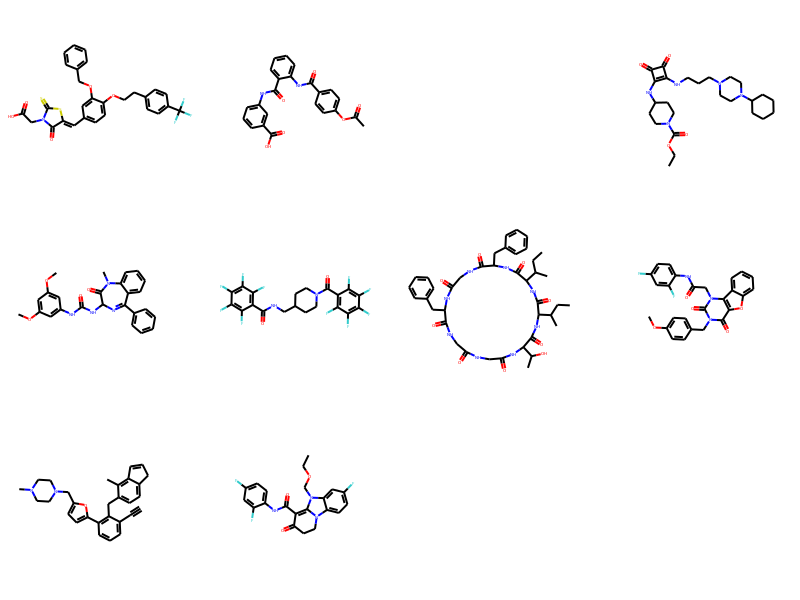

In [63]:
mols = [Chem.MolFromSmiles(s) for s in moleculesTmp]
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200,200))

In [65]:
import psycopg2

In [66]:
connection = psycopg2.connect(user = "chembl",
                              password = "chembl",
                              host = "127.0.0.1",
                              port = "5432",
                              database = "chembl_25")
cursor = connection.cursor()

In [74]:
cursor.execute('select * from COMPOUND_STRUCTURES where molregno = 204616')

In [75]:
fromDB = pd.DataFrame(cursor.fetchall())

In [81]:
fromDB.iloc[:, 4].values.shape

(1,)

In [80]:
connection.close()